In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

# FOR REPRODUCIBILITY
np.random.seed(7)

# Importing Dataset
dataset = pd.read_csv('apple_share_price.csv')
print(dataset)

           Date    Open    High     Low   Close     Volume
0     11-Aug-17  156.60  158.57  156.07  157.48   26257096
1     10-Aug-17  159.90  160.00  154.63  155.32   40804273
2      9-Aug-17  159.26  161.27  159.11  161.06   26131530
3      8-Aug-17  158.60  161.83  158.27  160.08   36205896
4      7-Aug-17  157.06  158.92  156.67  158.81   21870321
...         ...     ...     ...     ...     ...        ...
1659   7-Jan-11   47.71   48.05   47.41   48.02   77982212
1660   6-Jan-11   47.82   47.89   47.56   47.68   75106626
1661   5-Jan-11   47.08   47.76   47.07   47.71   63879193
1662   4-Jan-11   47.49   47.50   46.88   47.33   77337001
1663   3-Jan-11   46.52   47.18   46.41   47.08  111280407

[1664 rows x 6 columns]


In [2]:
len(dataset)

1664

In [3]:
# IMPORTING DATASET 
dataset = pd.read_csv('apple_share_price.csv', usecols=[1,2,3,4])
dataset = dataset.reindex(index = dataset.index[::-1])
print(dataset)

        Open    High     Low   Close
1663   46.52   47.18   46.41   47.08
1662   47.49   47.50   46.88   47.33
1661   47.08   47.76   47.07   47.71
1660   47.82   47.89   47.56   47.68
1659   47.71   48.05   47.41   48.02
...      ...     ...     ...     ...
4     157.06  158.92  156.67  158.81
3     158.60  161.83  158.27  160.08
2     159.26  161.27  159.11  161.06
1     159.90  160.00  154.63  155.32
0     156.60  158.57  156.07  157.48

[1664 rows x 4 columns]


In [4]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)
print(obs)

[   1    2    3 ... 1662 1663 1664]


In [5]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]
print(OHLC_avg)
print(close_val)

1663     46.7975
1662     47.3000
1661     47.4050
1660     47.7375
1659     47.7975
          ...   
4       157.8650
3       159.6950
2       160.1750
1       157.4625
0       157.1800
Length: 1664, dtype: float64
       Close
1663   47.08
1662   47.33
1661   47.71
1660   47.68
1659   48.02
...      ...
4     158.81
3     160.08
2     161.06
1     155.32
0     157.48

[1664 rows x 1 columns]


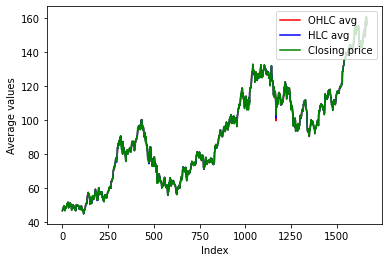

In [6]:
# PLOTTING ALL INDICATORS IN ONE PLOT
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.xlabel('Index')
plt.ylabel('Average values')
plt.show()


In [7]:
# PREPARATION OF TIME SERIES DATASET
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) # 1664
print(OHLC_avg)
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)
print(OHLC_avg)

[[ 46.7975]
 [ 47.3   ]
 [ 47.405 ]
 ...
 [160.175 ]
 [157.4625]
 [157.18  ]]
[[0.01530745]
 [0.0196717 ]
 [0.02058364]
 ...
 [1.        ]
 [0.97644172]
 [0.97398819]]


In [8]:
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [9]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)        

In [10]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)

trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [11]:
# RESHAPING TRAIN AND TEST DATA

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [12]:
# LSTM MODEL

model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [13]:
# MODEL COMPILING AND TRAINING

model.compile(loss='mean_squared_error', optimizer='adagrad') # Try SGD, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
1246/1246 - 8s - loss: 0.1057
Epoch 2/5
1246/1246 - 4s - loss: 0.0734
Epoch 3/5
1246/1246 - 4s - loss: 0.0592
Epoch 4/5
1246/1246 - 4s - loss: 0.0513
Epoch 5/5
1246/1246 - 4s - loss: 0.0467


In [15]:
# PREDICTION

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
print(trainPredict,testPredict)

[[0.25090855]
 [0.25114036]
 [0.25118876]
 ...
 [0.28153116]
 [0.2806891 ]
 [0.2796934 ]] [[0.27917707]
 [0.27791193]
 [0.27762324]
 [0.27775598]
 [0.2780879 ]
 [0.2783051 ]
 [0.27770078]
 [0.2780943 ]
 [0.278072  ]
 [0.27725875]
 [0.27632213]
 [0.27647048]
 [0.275056  ]
 [0.27378565]
 [0.2737522 ]
 [0.27402383]
 [0.27468443]
 [0.2742715 ]
 [0.2740023 ]
 [0.27321464]
 [0.27351916]
 [0.27290106]
 [0.27319086]
 [0.27466726]
 [0.27486277]
 [0.27455872]
 [0.27246034]
 [0.27195704]
 [0.2729357 ]
 [0.27306437]
 [0.272546  ]
 [0.27276796]
 [0.2730611 ]
 [0.2726467 ]
 [0.27218387]
 [0.27243   ]
 [0.2725914 ]
 [0.27195817]
 [0.27205473]
 [0.27285993]
 [0.27351165]
 [0.27361202]
 [0.27302003]
 [0.27317247]
 [0.2727539 ]
 [0.27249825]
 [0.27304384]
 [0.27346414]
 [0.27343392]
 [0.2742898 ]
 [0.27487242]
 [0.2751354 ]
 [0.27580595]
 [0.27554375]
 [0.27510643]
 [0.27513966]
 [0.27521366]
 [0.27556837]
 [0.27565828]
 [0.27656114]
 [0.27697784]
 [0.27711302]
 [0.2772407 ]
 [0.277313  ]
 [0.27729598]


In [16]:
# DE-NORMALIZING FOR PLOTTING

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
print(trainPredict,testPredict)

[[73.924614]
 [73.9513  ]
 [73.95687 ]
 ...
 [77.4505  ]
 [77.353546]
 [77.2389  ]] [[77.17945 ]
 [77.03378 ]
 [77.00054 ]
 [77.01582 ]
 [77.05404 ]
 [77.07905 ]
 [77.00947 ]
 [77.05478 ]
 [77.05221 ]
 [76.95857 ]
 [76.85073 ]
 [76.86781 ]
 [76.70495 ]
 [76.55868 ]
 [76.55483 ]
 [76.586105]
 [76.66216 ]
 [76.61462 ]
 [76.583626]
 [76.492935]
 [76.52799 ]
 [76.456825]
 [76.4902  ]
 [76.66019 ]
 [76.6827  ]
 [76.64769 ]
 [76.40608 ]
 [76.34814 ]
 [76.460815]
 [76.47563 ]
 [76.41595 ]
 [76.441505]
 [76.47526 ]
 [76.42754 ]
 [76.37425 ]
 [76.40259 ]
 [76.42117 ]
 [76.34827 ]
 [76.35938 ]
 [76.452095]
 [76.52713 ]
 [76.53869 ]
 [76.47053 ]
 [76.48808 ]
 [76.43988 ]
 [76.410446]
 [76.473274]
 [76.52166 ]
 [76.51818 ]
 [76.61673 ]
 [76.68381 ]
 [76.71409 ]
 [76.7913  ]
 [76.76111 ]
 [76.710754]
 [76.714584]
 [76.7231  ]
 [76.76394 ]
 [76.7743  ]
 [76.87825 ]
 [76.92623 ]
 [76.941795]
 [76.95649 ]
 [76.96482 ]
 [76.96286 ]
 [76.97644 ]
 [76.936035]
 [76.93799 ]
 [76.97228 ]
 [77.118645]
 [77.1

In [17]:
# TRAINING RMSE

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 24.42


In [18]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 45.07


In [19]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
print(trainPredictPlot)
trainPredictPlot[:, :] = np.nan
print(trainPredictPlot)
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict
print(trainPredictPlot)

[[6.91740688e-310]
 [6.91740688e-310]
 [4.66810257e-310]
 ...
 [3.95252517e-323]
 [4.66810259e-310]
 [0.00000000e+000]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[        nan]
 [73.92461395]
 [73.95130157]
 ...
 [        nan]
 [        nan]
 [        nan]]


In [20]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict


In [21]:
# DE-NORMALIZING MAIN DATASET 
print(OHLC_avg)
OHLC_avg = scaler.inverse_transform(OHLC_avg)
print(OHLC_avg)


[[0.01530745]
 [0.0196717 ]
 [0.02058364]
 ...
 [1.        ]
 [0.97644172]
 [0.97398819]]
[[ 46.7975]
 [ 47.3   ]
 [ 47.405 ]
 ...
 [160.175 ]
 [157.4625]
 [157.18  ]]


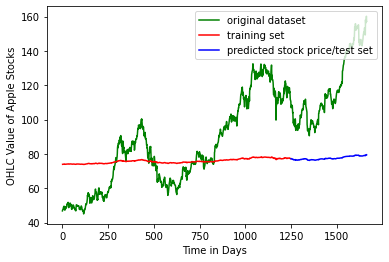

In [23]:

# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

In [29]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)

Last Day Value: 79.47308349609375
Next Day Value: 23.77019500732422


<ipython-input-29-07399bf6cb21>:5: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Last Day Value:", np.asscalar(last_val))
<ipython-input-29-07399bf6cb21>:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Next Day Value:", np.asscalar(last_val*next_val))
